# Summarize assemblies

In [23]:
import pandas as pd
from glob import glob
import os

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt

from qiime2.plugins.deicode.actions import rpca
from biom import Table, load_table
import qiime2 as q2
from qiime2.plugins.qurro.actions import differential_plot
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 

from skbio.stats.distance import permanova
from skbio import DistanceMatrix

# Assemblies

In [66]:
assembly_dirs=!ls assemblies 
print("{} assemblies total".format(len(assembly_dirs)))

719 assemblies total


Get assembly sizes

In [3]:
size_dict={}
assembly_files = !ls assemblies/pt*/final_assembly.fasta
for file in assembly_files:
    host_id = file.split('/')[1]
    tot_size = os.stat(file).st_size
    size_dict[host_id] = tot_size

assembly_size_df = pd.DataFrame.from_dict(size_dict, orient="index", columns=["assembly_size"])

____

# Genomic bins

In [2]:
bin_folders = !ls binning

out_list = []
for folder in bin_folders:
    try:
        checkm_file = pd.read_csv("binning/{}/maxbin2_bins.stats".format(folder), sep='\t')
        checkm_file["hostid"] = folder
        out_list.append(checkm_file)
    except:
        continue

checkm_df = pd.concat(out_list)

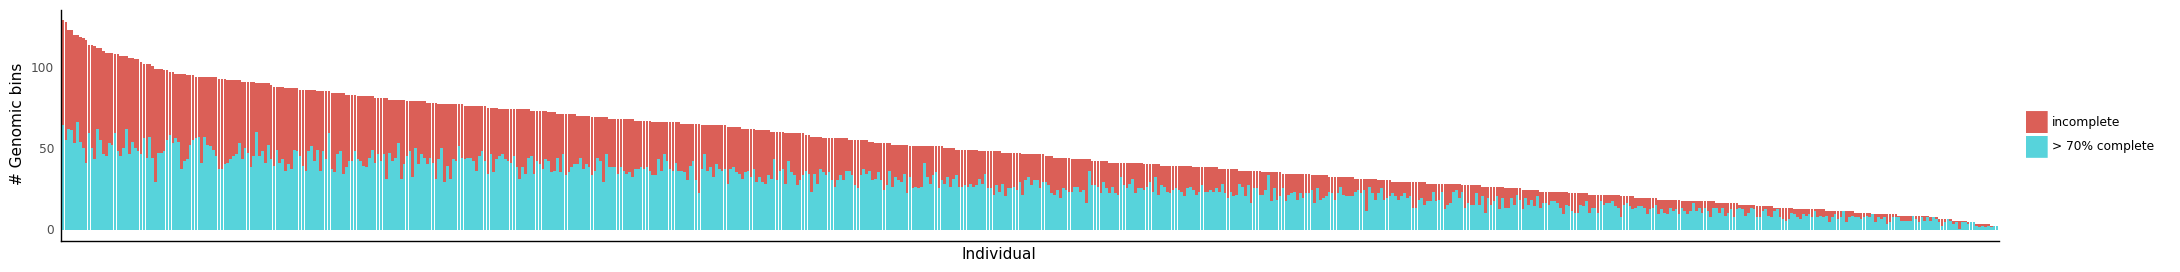

<ggplot: (8742878413432)>

In [214]:
pn.options.figure_size = (25, 3)

plot_dat = checkm_df.copy()
plot_dat["color"] = ["> 70% complete" if x > 70 else "incomplete" for x in plot_dat.completeness]
plot_dat["color"] = pd.Categorical(plot_dat["color"], categories=["incomplete","> 70% complete"])
oo = list (plot_dat.hostid.value_counts().index )
plot_dat["hostid"] = pd.Categorical(plot_dat.hostid, categories=oo)

p = (pn.ggplot(data = plot_dat) +
     pn.geom_bar( pn.aes(x="hostid", fill="color"), stat="count") +
     pn.labs( x="Individual", y="# Genomic bins", fill="") +
     pn.theme_classic() +
     pn.theme(axis_text_x = pn.element_blank(),
             axis_ticks = pn.element_blank())
    ) 
p

Text(0, 0.5, '# MAGs')

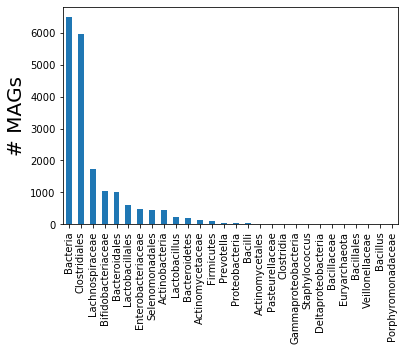

In [10]:
checkm_df.query('completeness > 70').lineage.value_counts().sort_values(ascending=False).plot(kind="bar")

plt.ylabel("# MAGs", size=20)


In [208]:
checkm_df

,bin,completeness,contamination,GC,lineage,N50,size,binner,hostid
0,bin.0,100.00,0.000,0.587,Bifidobacteriaceae,100554,2340334,binsA,pt200360
1,bin.1,99.36,0.632,0.413,Clostridiales,33874,4654334,binsA,pt200360
2,bin.2,95.44,2.056,0.321,Firmicutes,8580,2456004,binsA,pt200360
3,bin.3,96.60,2.397,0.457,Bacteroidales,31622,4571924,binsA,pt200360
4,bin.4,91.05,4.015,0.467,Lachnospiraceae,15446,2707076,binsA,pt200360
...,...,...,...,...,...,...,...,...,...
105,bin.95,82.47,35.420,0.311,Bacteria,6072,4021877,binsA,pt997004
106,bin.96,96.55,74.520,0.501,Bacteria,3221,3551464,binsA,pt997004
107,bin.97,62.13,2.192,0.440,Lachnospiraceae,3836,1338421,binsA,pt997004
108,bin.98,33.62,0.862,0.363,Bacteria,2243,481177,binsA,pt997004


# Prokka annotations

In [4]:
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova

In [5]:
#Import metadata
md = pd.read_table("../metadata/20190703_TEDDY_Cleaned_Metadata_v2.tsv")
host_md = md.groupby('host_subject_id').agg({'t1d':"first"})

size_md = pd.read_table("file_size_by_host.tsv", index_col=0)

host_md = host_md.merge(size_md, right_index=True, left_index=True)
host_md["Gb"] = host_md.bytes/1000000000
host_md["scale_factor"] = 1/host_md["Gb"]

host_md = host_md.merge(assembly_size_df, right_index=True, left_index=True)
host_md["assembly_mb"] = [x/1000000 for x in host_md.assembly_size]

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38,39,42,151,152,153,159,165,166,167,168,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,187,189,444,445,446,449,450,451,452,453,454,455,456,459,460,461,464,465,466,467,468,469,470,471,472) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
all_bins = glob("binning/pt*/maxbin_70_10_bins/prokka_annotation/*")

In [7]:
out_list = []
no_prokka_list = []
for bin_folder in all_bins:
    individual = bin_folder.split('/')[1]
    bin_id = bin_folder.split('/')[-1]
    annotation_file = "{}/{}.tsv".format(bin_folder,bin_id)
    try:
        file = pd.read_csv(annotation_file, sep='\t')
    except FileNotFoundError:
        no_prokka_list.append((individual, bin_id))
    file["host_id"] = individual
    out_list.append(file)
    
gene_df = pd.concat(out_list)

In [9]:
print(len(no_prokka_list))
print(len(out_list))

376
3451


In [39]:
#Collapse table to EC
tmp = gene_df.query('product!= "hypothetical protein"')\
    .groupby(['host_id'])["EC_number"]\
    .value_counts()\
    .to_frame()
tmp.columns=["tot"]
tmp = tmp.reset_index()
EC_abund_table = tmp.pivot_table(index='host_id', columns='EC_number', values="tot").fillna(0)

In [8]:
tmp = gene_df.groupby(['host_id'])["product"].value_counts().to_frame()
tmp.columns=["tot"]
tmp = tmp.reset_index()
tmp = tmp.query('product != "hypothetical protein"')
abund_table = tmp.pivot_table(index='host_id', columns='product', values="tot").fillna(0)

## Beta diversity and PERMANOVA

Calculate bray-curtis and jaccard distance and run permanova

In [18]:
#Convert to qza for Deicode
abund_table_format = abund_table.copy()
abund_table_format.columns = [str(i) + '_' + x for i,x in enumerate(abund_table_format)]

bt = Table(data=abund_table_format.transpose().to_numpy(), observation_ids=list(abund_table_format.columns), sample_ids=list(abund_table_format.index), type="OTU table")
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt)

In [32]:
#Deicode distance
deicode_bplt_qza, deicode_dm_qza = rpca(qza)
deicode_dm = deicode_dm_qza.view(DistanceMatrix)
#Brat-curtis distance
bc_dist = beta_diversity(metric="braycurtis", counts=abund_table.values, ids=abund_table.index)
#Jaccard distance
jaccard_dist = beta_diversity(metric="jaccard", counts=abund_table.values, ids=abund_table.index)

#Calculate PERMANOVAS
bc_perm = permanova(bc_dist, grouping=host_md, column="t1d")
jaccard_perm = permanova(jaccard_dist, grouping=host_md, column="t1d")
deicode_perm = permanova(deicode_dm, grouping=host_md, column="t1d")

perm_df = pd.DataFrame([deicode_perm,jaccard_perm,bc_perm], index=["Deicode","Jaccard","Bray-Curtis"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [33]:
perm_df

,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
Deicode,PERMANOVA,pseudo-F,224,2,0.216749,0.803,999
Jaccard,PERMANOVA,pseudo-F,224,2,1.231763,0.189,999
Bray-Curtis,PERMANOVA,pseudo-F,224,2,1.042647,0.306,999


EC level

In [49]:
#Convert to qza for Deicode
EC_abund_table_format = EC_abund_table.copy()
EC_abund_table_format.columns = [str(i) + '_' + x for i,x in enumerate(EC_abund_table_format)]

EC_bt = Table(data=EC_abund_table_format.transpose().to_numpy(), observation_ids=list(EC_abund_table_format.columns), sample_ids=list(EC_abund_table_format.index), type="OTU table")
EC_qza = q2.Artifact.import_data('FeatureTable[Frequency]', EC_bt)


In [50]:
#Deicode distance
deicode_bplt_qza, deicode_dm_qza = rpca(EC_qza)
deicode_dm = deicode_dm_qza.view(DistanceMatrix)
#Brat-curtis distance
bc_dist = beta_diversity(metric="braycurtis", counts=EC_abund_table.values, ids=EC_abund_table.index)
#Jaccard distance
jaccard_dist = beta_diversity(metric="jaccard", counts=EC_abund_table.values, ids=EC_abund_table.index)

#Calculate PERMANOVAS
bc_perm = permanova(bc_dist, grouping=host_md, column="t1d")
jaccard_perm = permanova(jaccard_dist, grouping=host_md, column="t1d")
deicode_perm = permanova(deicode_dm, grouping=host_md, column="t1d")

EC_perm_df = pd.DataFrame([deicode_perm,jaccard_perm,bc_perm], index=["Deicode","Jaccard","Bray-Curtis"])
EC_perm_df

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
Deicode,PERMANOVA,pseudo-F,224,2,1.505776,0.217,999
Jaccard,PERMANOVA,pseudo-F,224,2,1.040825,0.335,999
Bray-Curtis,PERMANOVA,pseudo-F,224,2,0.986379,0.326,999


## Songbird differential abundance

In [47]:
#Import metadata to qiime2
host_md.index.name="featureid"
q2_md = q2.Metadata(host_md)

In [48]:
from zipfile import ZipFile
def get_q2(file):
    """Given path to modela_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)

100%|██████████| 43000/43000 [03:13<00:00, 222.34it/s]


NameError: name 'tmp_qurro' is not defined

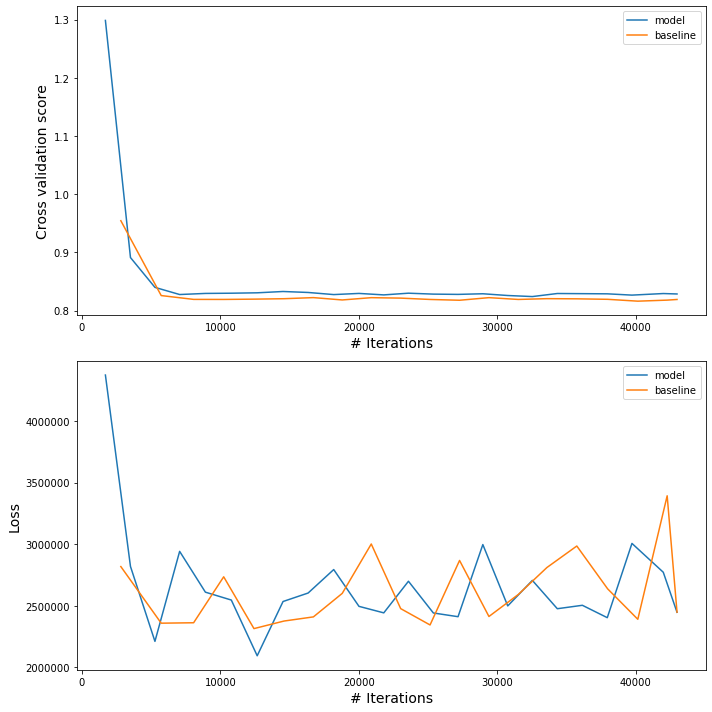

In [184]:
#Run/Import Songbird
folder="gene_songbird"
!mkdir -p $folder

formula = "t1d"
songbird_dict = {}

#Run Songbird
(temp_differentials,
 temp_regression_stats,
 temp_regression_biplot) = multinomial(table=qza,
                                       metadata=q2_md,
                                       formula=formula,
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run null model (just sex)
(null_differentials,
 null_regression_stats,
 null_regression_biplot) = multinomial(table=qza,
                                       metadata=q2_md,
                                       formula="1",
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run qurro
#tmp_qurro = differential_plot(ranks= temp_differentials,
#                                table= qza,
#                                sample_metadata=q2_md).visualization
#Evaluate model fit
tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                baseline_stats = null_regression_stats).visualization



#Add outputs to master dictionary
songbird_dict["differentials"] = temp_differentials
songbird_dict["regression_stats"] = temp_regression_stats
songbird_dict["regression_biplot"] = temp_regression_biplot
#songbird_dict["qurro"] = tmp_qurro
songbird_dict["model_fit"] = tmp_model_fit
#Save outputs
temp_differentials.save("{}/met_differentials.qza".format(folder))
temp_regression_stats.save("{}/met_regression_stats.qza".format(folder))
temp_regression_biplot.save("{}/met_regression_biplot.qza".format(folder))
#tmp_qurro.save("{}/met_qurro.qzv".format(folder))
tmp_model_fit.save("{}/met_model_fit.qzv".format(folder))

#Save q2 value
q2_value = get_q2("{}/met_model_fit.qzv".format(folder))
                                                    



Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






  0%|          | 0/43000 [00:00<?, ?it/s]

100%|██████████| 43000/43000 [02:35<00:00, 277.21it/s]


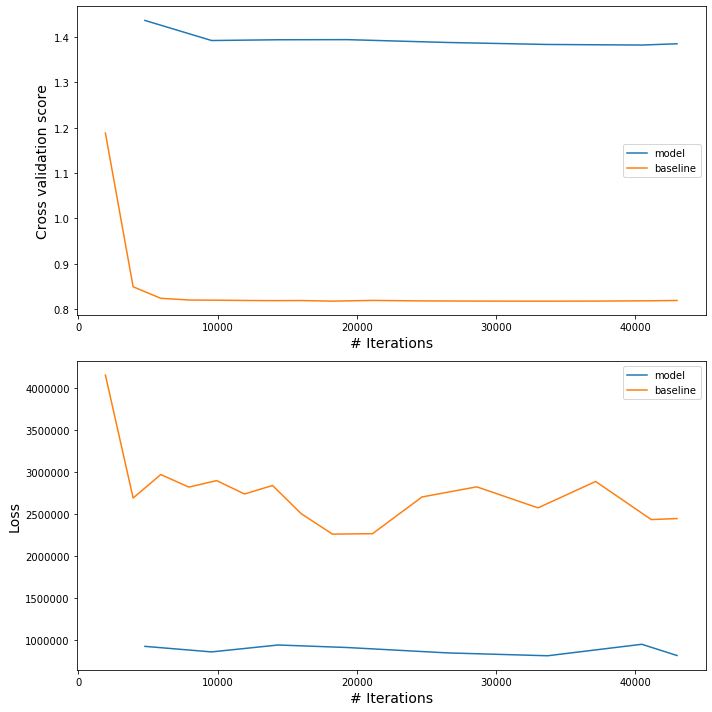

In [51]:
#Run/Import Songbird
folder="EC_songbird"
!mkdir -p $folder

formula = "t1d"
songbird_dict = {}

#Run Songbird
(temp_differentials,
 temp_regression_stats,
 temp_regression_biplot) = multinomial(table=EC_qza,
                                       metadata=q2_md,
                                       formula=formula,
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run null model (just sex)
(null_differentials,
 null_regression_stats,
 null_regression_biplot) = multinomial(table=qza,
                                       metadata=q2_md,
                                       formula="1",
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run qurro
#tmp_qurro = differential_plot(ranks= temp_differentials,
#                                table= qza,
#                                sample_metadata=q2_md).visualization
#Evaluate model fit
tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                baseline_stats = null_regression_stats).visualization



#Add outputs to master dictionary
songbird_dict["differentials"] = temp_differentials
songbird_dict["regression_stats"] = temp_regression_stats
songbird_dict["regression_biplot"] = temp_regression_biplot
#songbird_dict["qurro"] = tmp_qurro
songbird_dict["model_fit"] = tmp_model_fit
#Save outputs
temp_differentials.save("{}/met_differentials.qza".format(folder))
temp_regression_stats.save("{}/met_regression_stats.qza".format(folder))
temp_regression_biplot.save("{}/met_regression_biplot.qza".format(folder))
#tmp_qurro.save("{}/met_qurro.qzv".format(folder))
tmp_model_fit.save("{}/met_model_fit.qzv".format(folder))

#Save q2 value
q2_value = get_q2("{}/met_model_fit.qzv".format(folder))
                                                    

In [185]:
tmp_model_fit.save("{}/met_model_fit.qzv".format(folder))

#Save q2 value
q2_value = get_q2("{}/met_model_fit.qzv".format(folder))

In [186]:
#Gene produce q2
q2_value

'-0.010589'

In [52]:
#EC q2
q2_value

'-1.346794'

In [53]:
#EC
diff_df = temp_differentials.view(pd.DataFrame)
diff_df = diff_df.merge()
diff_df.sort_values('t1d[T.yes]').tail(20)

,Intercept,t1d[T.yes]
featureid,,
1965_4.6.1.13,-0.784888,0.708101
476_1.5.3.1,-2.175455,0.712900
1901_4.2.2.25,-3.266110,0.720860
191_1.11.1.23,-2.206014,0.732636
635_2.1.1.35,-2.828352,0.765372
503_1.7.1.6,-3.580773,0.772001
954_2.6.1.34,-2.117286,0.804083
431_1.3.99.38,-2.206535,0.851070
938_2.6.1.106,-2.108780,0.854621


In [60]:
gene_df.query('EC_number == "2.7.1.193"')

,locus_tag,ftype,length_bp,gene,EC_number,COG,product,host_id
541,FKEDANPP_00542,CDS,231,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt403321
1363,BKGFEKIO_01362,CDS,231,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt334835
22614,APMGBJGA_22608,CDS,231,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt375687
25145,BMOBNMBO_25139,CDS,249,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt232785
1410,LJNJCCDK_01410,CDS,231,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt405855
9535,GDNFOFDL_09528,CDS,267,nagF_1,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt417341
9538,GDNFOFDL_09531,CDS,240,nagF_2,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt417341
27568,EAFNMFIB_27559,CDS,231,nagF_1,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt354956
27569,EAFNMFIB_27560,CDS,249,nagF_2,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt354956
875,PEKJGKEC_00876,CDS,231,nagF,2.7.1.193,COG1264,PTS system N-acetylglucosamine-specific EIIB c...,pt399629


In [57]:
gene_df

,locus_tag,ftype,length_bp,gene,EC_number,COG,product,host_id
0,DLGGKFLE_00001,CDS,972,prfB,NaN,NaN,Peptide chain release factor 2,pt403321
1,DLGGKFLE_00002,CDS,726,yfiC,2.1.1.223,COG4123,tRNA1(Val) (adenine(37)-N6)-methyltransferase,pt403321
2,DLGGKFLE_00003,CDS,462,fabZ,4.2.1.59,NaN,3-hydroxyacyl-[acyl-carrier-protein] dehydrata...,pt403321
3,DLGGKFLE_00004,CDS,1026,mbl,NaN,COG1077,Cell shape-determining protein Mbl,pt403321
4,DLGGKFLE_00005,CDS,810,NaN,NaN,NaN,hypothetical protein,pt403321
...,...,...,...,...,...,...,...,...
4657,FBBBMBLM_04656,CDS,1194,tuf,NaN,COG0050,Elongation factor Tu,pt291640
4658,FBBBMBLM_04657,CDS,207,NaN,NaN,NaN,hypothetical protein,pt291640
4659,FBBBMBLM_04658,CDS,555,NaN,NaN,NaN,hypothetical protein,pt291640
4660,FBBBMBLM_04659,CDS,288,NaN,NaN,NaN,hypothetical protein,pt291640


In [187]:
diff_df = temp_differentials.view(pd.DataFrame)

In [188]:
diff_df.sort_values('t1d[T.yes]').tail(20)

,Intercept,t1d[T.yes]
featureid,,
194_2-oxoglutarate dehydrogenase E1/E2 component,-2.132793,1.112804
299_3-methyl-2-oxobutanoate dehydrogenase subunit alpha,-2.795247,1.118941
6423_Peptide methionine sulfoxide reductase MsrA 2,-1.791343,1.121853
9051_Zinc metalloprotease Rip1,-1.263212,1.136270
3008_Glucosamine kinase,-1.649524,1.141686
2596_Extracellular basic protease,-2.426616,1.161496
5908_NADH-quinone oxidoreductase subunit D,-1.385543,1.197945
6117_Nucleoid-associated protein Lsr2,-1.232576,1.200243
2772_Flavin reductase,-2.910897,1.206745


In [224]:
prev_t1d_df = gene_df_.groupby(['t1d',"locus_tag"])\
    .agg({"presence_absense":lambda x: sum(x)/len(x), "product":"first"})\
    .reset_index()\
    .pivot_table(index="locus_tag", columns="t1d", values="presence_absense")\
    .fillna(0)

prev_t1d_df["difference"] = prev_t1d_df.yes - prev_t1d_df.no

KeyError: 'locus_tag'

In [77]:
prev_t1d_df.sort_values("difference")

t1d,no,yes,difference
product,,,
Amino-acid permease RocE,0.506579,0.15,-0.356579
putative cystine transporter YijE,0.815789,0.50,-0.315789
N-acetylmuramoyl-L-alanine amidase,0.506579,0.20,-0.306579
IS66 family transposase ISCde1,0.453947,0.15,-0.303947
NAD-dependent dihydropyrimidine dehydrogenase subunit PreT,0.750000,0.45,-0.300000
...,...,...,...
GTPase Obg/CgtA,0.388158,0.70,0.311842
Lipoate--protein ligase 1,0.427632,0.75,0.322368
3-methylitaconate isomerase,0.375000,0.70,0.325000


Scale by assembly depth

In [54]:
t1d_df = gene_df_.groupby(['t1d',"product"])\
    .agg({"value":"sum"})\
    .reset_index()\
    .pivot_table(index="product", columns="t1d", values="value")\
    .fillna(0)
t1d_df = t1d_df.apply(axis=0, func= lambda col: col/sum(col))
t1d_df["difference"] = t1d_df.yes - t1d_df.no

t1d_df.sort_values("difference").tail(20)

t1d,no,yes,difference
product,,,
Nickel import system permease protein NikB,0.000069,0.000160,0.000091
Beta-N-acetylglucosaminidase/beta-glucosidase,0.000106,0.000197,0.000091
Trans-feruloyl-CoA synthase FCS1,0.000099,0.000191,0.000092
ATP synthase subunit beta 1,0.000048,0.000142,0.000094
putative protein YacP,0.000091,0.000187,0.000095
Iron-sulfur cluster repair protein ScdA,0.000037,0.000133,0.000096
ECF RNA polymerase sigma factor SigL,0.000094,0.000190,0.000096
Putative lipid kinase,0.000099,0.000197,0.000098
Nuclease,0.000071,0.000169,0.000098


In [60]:
def plot_gene(df, gene):
    plot_dat = df.query('product == @gene')

    pn.options.figure_size = (1.5,2.5)
    p = (pn.ggplot(data = plot_dat) +
         pn.geom_boxplot( pn.aes(x = "t1d", y="value"), outlier_alpha=0) +
         pn.geom_jitter( pn.aes(x="t1d", y="value"), size=1, alpha=.8, width=.1)


        )
    return(p)

Plot Number of samples per individual

Text(0.5, 0, '# Samples')

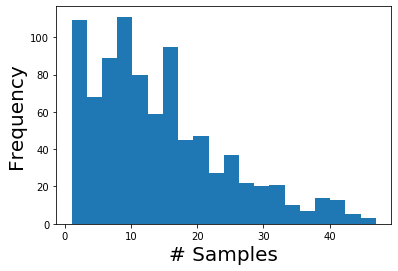

In [9]:
md.host_subject_id.value_counts().plot(kind="hist", bins=20)
#plt.xlabel("# Samples")
plt.ylabel("Frequency", size=20)
plt.xlabel("# Samples", size=20)

___

Jaccard distance

In [83]:
pres_abs_table = gene_df_.pivot_table(index="product", columns="host_id", values="presence_absense")

In [117]:
from skbio.diversity import beta_diversity
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa

In [109]:
x = pres_abs_table.transpose().values.tolist()
tmp = beta_diversity(metric="jaccard", counts=x, ids=pres_abs_table.columns)

In [115]:
jaccard_df = tmp.to_data_frame()

In [199]:
jaccard_pcoa = pcoa(tmp)
jaccard_pcoa_values = jaccard_pcoa.samples
jaccard_pcoa_values = jaccard_pcoa_values.merge(host_md, left_index=True, right_index=True)

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.010461214444895355 and the largest is 4.82076756990163.
  RuntimeWarning


In [153]:
#Get data for RDA
data_for_rda = jaccard_pcoa.samples.loc[:,["PC1","PC2","PC3"]].sort_index()

#Get metadata for RDA
data_samples = set (data_for_rda.index )
md_for_rda = md.query('host_subject_id in @data_samples').sort_index()
all([x==y for x,y in zip(md_for_rda.index,data_for_rda.index)])

False

In [159]:
md.bmi_z_score.value_counts()

not provided    12521
Name: bmi_z_score, dtype: int64

In [202]:
host_md.assembly_mb.sum() /1000

121.858978565

In [ ]:
rda_variables = ["sex",
                "t1d",
                ]

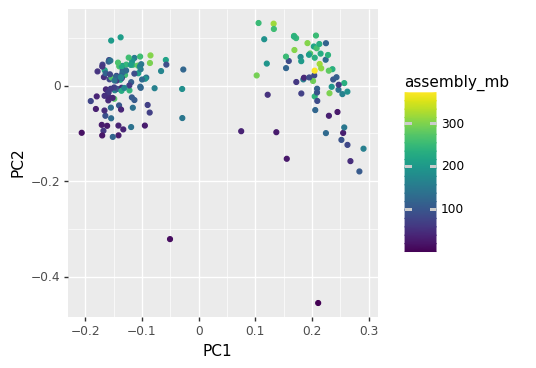

<ggplot: (8742904570204)>

In [200]:
pn.options.figure_size = (4,4)

p = (pn.ggplot(data = jaccard_pcoa_values) +
     pn.geom_point( pn.aes( x= "PC1", y="PC2", color="assembly_mb"))
    
    )
p

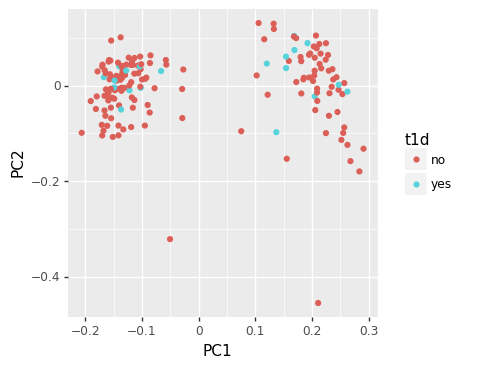

<ggplot: (8742665927288)>

In [169]:
pn.options.figure_size = (4,4)

p = (pn.ggplot(data = jaccard_pcoa_values) +
     pn.geom_point( pn.aes( x= "PC1", y="PC2", color="t1d"))
    
    )
p

Run stepwise RDA to find what is separating points

In [ ]:
%%script bash 

source ~/.bash_profile
conda activate qiime2-2020.2

root_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/ordistep
Rfile=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/stepwise-rda.R

declare -A datasets=( [all]=$root_dir/rda_deicode_data_all.tsv
                     [Stool]=$root_dir/rda_deicode_data_Stool.tsv
                     [Oral]=$root_dir/rda_deicode_data_Oral.tsv
                    [Skin]=$root_dir/rda_deicode_data_Skin.tsv )

declare -A metadatas=( [all]=$root_dir/rda_md_all.tsv
                     [Stool]=$root_dir/rda_md_Stool.tsv
                     [Oral]=$root_dir/rda_md_Oral.tsv
                    [Skin]=$root_dir/rda_md_Skin.tsv )


for subset in {all,Stool,Oral,Skin}
    do
    out_file=$root_dir/deicode_ordistep_results_${subset}.tsv
    Rscript $Rfile ${datasets[$subset]} ${metadatas[$subset]} $out_file
    done


In [256]:
gene="TonB-dependent receptor P3"
tonb_genes = set(x for x in filled_gene_df["product"] if "TonB" in x)
plot_dat = filled_gene_df.query('product in @tonb_genes')\
                    .groupby(['t1d','host_id','product']).\
                    agg({'value':sum})\
                    .reset_index()

pn.options.figure_size = (8,2.5)
p = (pn.ggplot(data = plot_dat) +
     pn.geom_boxplot( pn.aes(x = "t1d", y="value"), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="t1d", y="value"), size=.6, width=.1) +
     pn.facet_grid('.~product') +
    #pn.scale_y_continuous(limits=[0,.5])

        )
p

SyntaxError: invalid syntax (<ipython-input-256-ed00d1911266>, line 15)

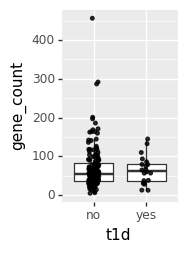

<ggplot: (-9223363293976328532)>

In [23]:
gene="L-arabinose transport system permease protein AraQ"
plot_gene(gene_df_, gene)

In [72]:
t1d_df = pd.DataFrame(gene_df_.groupby('t1d')["product"].value_counts())
t1d_df.columns=["gene"]
t1d_df = t1d_df.reset_index()

In [135]:
t1d_pivot = t1d_df.pivot_table(index="product", columns="t1d", values="gene").fillna(0)
t1d_pivot = t1d_pivot.apply(axis=0, func = lambda col:col/sum(col))
t1d_pivot["difference"] = t1d_pivot.yes - t1d_pivot.no


TonB-dependent transporters (TBDTs) are bacterial outer membrane proteins that bind and transport ferric chelates called siderophores, as well as vitamin B12, nickel complexes, and carbohydrates

In [139]:
t1d_pivot.head(60)

t1d,no,yes,difference
product,,,
(-)-trans-carveol dehydrogenase,1.854249e-07,0.000000,-1.854249e-07
"(2E,6E)-farnesyl diphosphate synthase",2.503236e-05,0.000041,1.633721e-05
(2R)-3-sulfolactate dehydrogenase (NADP(+)),3.708497e-07,0.000000,-3.708497e-07
(2R)-sulfolactate sulfo-lyase subunit beta,1.891334e-05,0.000008,-1.063942e-05
"(2Z,6E)-farnesyl diphosphate synthase",3.337648e-06,0.000010,6.591048e-06
(3S)-malyl-CoA thioesterase,1.854249e-07,0.000000,-1.854249e-07
"(4S)-4-hydroxy-5-phosphonooxypentane-2,3-dione isomerase",1.928419e-05,0.000018,-1.081578e-06
(6-4) photolyase,3.708497e-07,0.000000,-3.708497e-07
(E)-2-((N-methylformamido)methylene)succinate hydrolase,7.231570e-06,0.000010,2.697126e-06


In [144]:
t1d_pivot.sort_values('difference').iloc[500:550]

t1d,no,yes,difference
product,,,
IS91 family transposase ISAzo26,0.000039,0.000025,-0.000014
Acetyl-CoA:oxalate CoA-transferase,0.000049,0.000035,-0.000014
Zinc import ATP-binding protein ZnuC,0.000049,0.000035,-0.000014
"L-serine dehydratase, alpha chain",0.000180,0.000165,-0.000014
Chitinase A1,0.000022,0.000008,-0.000014
L(+)-tartrate dehydratase subunit alpha,0.000262,0.000248,-0.000014
putative lipoprotein YgdR,0.000041,0.000026,-0.000014
Cytosine deaminase,0.000041,0.000026,-0.000014
D-alanine aminotransferase,0.000062,0.000048,-0.000014


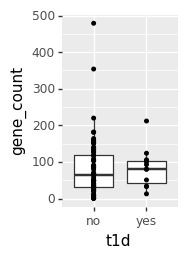

<ggplot: (-9223363288474632949)>

In [180]:
gene="TonB-dependent receptor P3"
plot_gene(gene_df_, gene)